In [1]:
import contextily as cx
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../utils')
from helper_functions import combine_zip_codes_and_county_geos, total_vehicles_and_evs_by_zip, city_geos

In [2]:
# Get a mapping of California zip codes to counties
# This also includes 2017 population
zip_code_path = "../geojsons/California_Zip_Codes.geojson"
counties_path = "../geojsons/California_County_Boundaries.geojson"
zip_county_mapper = combine_zip_codes_and_county_geos(zip_code_path, counties_path)[['zip_code', 'po_name', 'population', 'county_name', 'county_abbrev']]
zip_county_mapper.rename(columns = {'population': 'pop_2017'}, inplace = True)
zip_county_mapper.pop_2017 = zip_county_mapper.pop_2017.astype(str)

Reading in geojson files...
California has 1721 zip codes and 69 counties
Our join lost us 4 zip codes out of 1721


In [3]:
# Get California 2021 population
pop_2021 = pd.read_csv('../vehicle_data/california_pop_by_zip_code.csv', thousands=',')[['zip_code', 'population_2021']]
pop_2021.rename(columns = {'population_2021': 'pop_2021'}, inplace = True)
pop_2021 = pop_2021.astype({'zip_code': 'str', 'pop_2021': 'int64'})

# Join California 2021 population onto zip and county data
zip_county_mapper_final = zip_county_mapper.merge(pop_2021, on='zip_code', how='left')

### Vehicle Counts - focus on 2022 and 2021

In [5]:
v_and_ev_by_zip_2022 = total_vehicles_and_evs_by_zip('../vehicle_data/vehicle-fuel-type-count-by-zip-code-2022.csv', 2022)
v_and_ev_by_zip_2021 = total_vehicles_and_evs_by_zip('../vehicle_data/vehicle-fuel-type-count-by-zip-code-2021.csv', 2021)

/Users/danielwilentz/Desktop/job_search_2023/vehicle_type_project/analysis/../utils/helper_functions.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['vehicles'], 0)
/Users/danielwilentz/Desktop/job_search_2023/vehicle_type_project/analysis/../utils/helper_functions.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['v

In [9]:
v_and_ev_by_zip_2021.head()

,zip_code,vehicles,evs
0,90000,2,0
1,90001,2954,97
2,90002,2542,78
3,90003,3313,115
4,90004,4920,705


### Merge vehicle counts and evs to zip code mapper

In [28]:
zip_county_vehicles = zip_county_mapper_final.merge(v_and_ev_by_zip_2022, 
                                                    on='zip_code', 
                                                    how = 'left')
zip_county_vehicles.rename(columns = {'vehicles': 'vehicles_2022', 'evs': 'evs_2022'}, inplace = True)
zip_county_vehicles = zip_county_vehicles.merge(v_and_ev_by_zip_2021, 
                                                    on='zip_code', 
                                                    how = 'left')
zip_county_vehicles.rename(columns = {'vehicles': 'vehicles_2021', 'evs': 'evs_2021'}, inplace = True)

In [29]:
# Process data anomalies
# Some zip codes have no reported vehicles reported as NaN - we'll replace these with 0s
# Some zip codes (such as national forests or parks) have no population recorded with -99 as the flag for this. 
# We'll convert this to 0s as well
county_info = zip_county_vehicles[['county_name', 'pop_2017', 'pop_2021', 'vehicles_2022', 'evs_2022', 'vehicles_2021', 'evs_2021']]
county_info = county_info.fillna(0)
cols_to_convert = ['pop_2017', 'pop_2021', 'vehicles_2022', 'evs_2022', 'vehicles_2021', 'evs_2021']
county_info[cols_to_convert] = county_info[cols_to_convert].astype(int)
county_info['pop_2017'] = county_info['pop_2017'].clip(lower=0)

In [30]:
# Sum up all zip code populations and vehicles within a county
county_info = county_info.groupby(['county_name'])[cols_to_convert].sum().reset_index()

In [31]:
county_info['ev_rate_2022'] = round(county_info['evs_2022']/county_info['vehicles_2022']*100, 2)
county_info['ev_rate_2021'] = round(county_info['evs_2021']/county_info['vehicles_2021']*100, 2)

### Extrapolate which counties are on target for 2026

In [34]:
county_info.head()

,county_name,pop_2017,pop_2021,vehicles_2022,evs_2022,vehicles_2021,evs_2021,ev_rate_2022,ev_rate_2021,2022_yoy_improvement,ev_rate_2026_extrap,2026_target_hit
0,Alameda,1657674,1690090,115326,35014,125027,28994,30.36,23.19,7.17,59.04,True
1,Alpine,901,1061,55,13,49,6,23.64,12.24,11.40,69.24,True
2,Amador,36396,38650,2394,262,2530,183,10.94,7.23,3.71,25.78,False
3,Butte,228784,217125,11851,1476,13003,1045,12.45,8.04,4.41,30.09,False
4,Calaveras,43649,42709,3114,327,3253,244,10.50,7.50,3.00,22.50,False


In [90]:
# Extrapolate
# Based on the difference between 2021 and 2022, if we assume the same linear increase each year,
# Do we see counties hitting the 35% target by 2026?

county_info['2022_yoy_improvement'] = county_info['ev_rate_2022'] - county_info['ev_rate_2021']
county_info['ev_rate_2026_extrap'] = county_info['2022_yoy_improvement']*4 + county_info['ev_rate_2022']
county_info['2026_target_hit'] = county_info['ev_rate_2026_extrap'] >= 35.0
county_info['color'] = np.where(county_info['2026_target_hit'], 'limegreen', 'tomato')

### Add in geography data

In [91]:
# Read in county geojson - we will use this for plotting
counties = gpd.read_file(counties_path)
counties.columns= counties.columns.str.lower()

# Dedupping columns. There are multiple instances of slightly different geometries for:
# Los Angeles, Santa Barbara, and Ventura Counties
counties['rank'] = counties.groupby('county_name')['objectid'].rank(method='first')
counties = counties[counties['rank'] == 1]

# subset county gdf to only get county name and geometry
county_geoms = counties[['county_name', 'geometry']]

In [92]:
# merge county vehicle count info with geometries
county_df = county_info.merge(county_geoms, on = 'county_name', how = 'left')

In [93]:
# convert county df to county gdf
county_gdf = gpd.GeoDataFrame(county_df[['county_name', 
                                         'pop_2017', 
                                         'pop_2021', 
                                         'vehicles_2022', 
                                         'evs_2022', 
                                         'vehicles_2021',
                                         'evs_2021',
                                         'ev_rate_2022',
                                         'ev_rate_2021',
                                         '2022_yoy_improvement',
                                         'ev_rate_2026_extrap',
                                         '2026_target_hit',
                                         'color']], 
                 geometry=county_df['geometry'])

In [94]:
# set gdf crs to 3857
county_gdf.to_crs(3857, inplace=True)

In [95]:
# Grab city information
cities_path = "../geojsons/City_Boundaries.geojson"
cities = city_geos(cities_path)

### Plots

Text(0.5, 1.0, 'CA EV Adoption Rate (2022) by County')

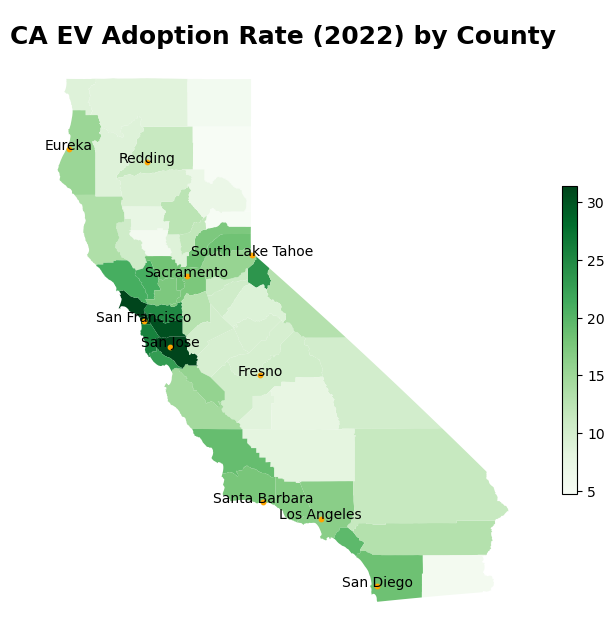

In [96]:
# EV Adoption Rate 2022

fig, ax = plt.subplots(figsize = (8, 8))
county_gdf.plot(ax=ax,
                column='ev_rate_2022', 
                legend=True, 
                legend_kwds={'shrink':0.5},
                cmap = 'Greens')
cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('CA EV Adoption Rate (2022) by County', size=18, weight='bold')

Text(0.5, 1.0, 'Expected Outcome by County: 35% Car Sales are EVs by 2026')

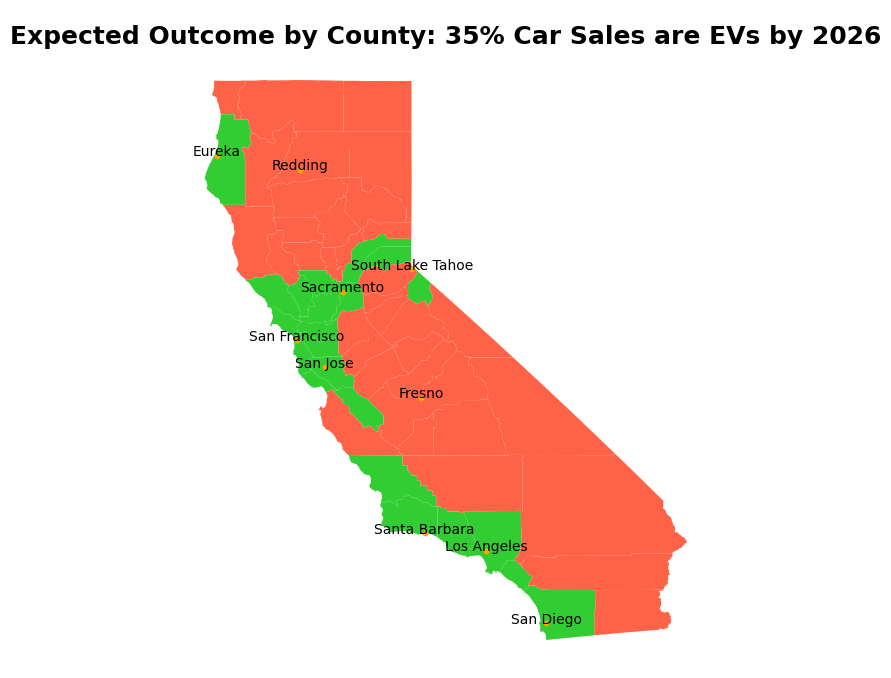

In [114]:
# Which counties are on track to hit target?

fig, ax = plt.subplots(figsize = (8, 8))
county_gdf.plot(ax=ax,
                categorical = True,
                column='2026_target_hit',
                legend = True,
                color = county_gdf['color'])
cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('Expected Outcome by County: 35% Car Sales are EVs by 2026', size=18, weight='bold')

In [107]:
# Overall stats
california_summary = county_gdf[['vehicles_2022', 'evs_2022', 'vehicles_2021', 'evs_2021']].sum()
ev_rate_2022 = round(california_summary['evs_2022']/california_summary['vehicles_2022']*100, 2)
ev_rate_2021 = round(california_summary['evs_2021']/california_summary['vehicles_2021']*100, 2)
pct_change = round((ev_rate_2022 - ev_rate_2021)/ev_rate_2021*100, 2)

print(f'Overall, California had an EV adoption rate of {ev_rate_2022}% in 2022 and {ev_rate_2021} in 2021')
print(f"That's a percent change of {pct_change} year over year.")

Overall, California had an EV adoption rate of 17.81% in 2022 and 12.73 in 2021
That's a percent change of 39.91 year over year.


In [101]:
# Counties with the lowest ev_rate in 2022
county_gdf.sort_values(by=['ev_rate_2022']).head(5)

,county_name,pop_2017,pop_2021,vehicles_2022,evs_2022,vehicles_2021,evs_2021,ev_rate_2022,ev_rate_2021,2022_yoy_improvement,ev_rate_2026_extrap,2026_target_hit,color,geometry
17,Lassen,28608,27874,1228,58,1224,28,4.72,2.29,2.43,14.44,False,tomato,"MULTIPOLYGON (((-13358317.884 5039557.911, -13..."
45,Sierra,3659,3380,199,10,208,9,5.03,4.33,0.70,7.83,False,tomato,"MULTIPOLYGON (((-13374730.421 4823568.308, -13..."
12,Imperial,199124,185175,20034,1101,18302,488,5.50,2.67,2.83,16.82,False,tomato,"MULTIPOLYGON (((-12760361.612 3952564.998, -12..."
5,Colusa,21899,21323,1677,93,1685,62,5.55,3.68,1.87,13.03,False,tomato,"MULTIPOLYGON (((-13568737.197 4776816.356, -13..."
24,Modoc,8130,7962,372,21,382,9,5.65,2.36,3.29,18.81,False,tomato,"MULTIPOLYGON (((-13508307.448 5160450.254, -13..."


In [102]:
# Counties with the highest ev_rate in 2022
county_gdf.sort_values(by=['ev_rate_2022'], ascending = False).head(5)

,county_name,pop_2017,pop_2021,vehicles_2022,evs_2022,vehicles_2021,evs_2021,ev_rate_2022,ev_rate_2021,2022_yoy_improvement,ev_rate_2026_extrap,2026_target_hit,color,geometry
37,San Francisco,840385,836226,53555,16815,54397,12676,31.40,23.30,8.10,63.80,True,limegreen,"MULTIPOLYGON (((-13622595.330 4563001.785, -13..."
20,Marin,295258,295839,26474,8268,27893,6433,31.23,23.06,8.17,63.91,True,limegreen,"MULTIPOLYGON (((-13639782.868 4553234.009, -13..."
42,Santa Clara,1944903,1918423,147613,46102,161111,40317,31.23,25.02,6.21,56.07,True,limegreen,"MULTIPOLYGON (((-13524557.408 4506504.112, -13..."
0,Alameda,1657674,1690090,115326,35014,125027,28994,30.36,23.19,7.17,59.04,True,limegreen,"MULTIPOLYGON (((-13611173.233 4566017.932, -13..."
40,San Mateo,781302,777460,82564,21333,101963,16052,25.84,15.74,10.10,66.24,True,limegreen,"MULTIPOLYGON (((-13624775.603 4538293.155, -13..."


In [104]:
# Counties with the highest ev_rate yoy improvement in 2022
county_gdf.sort_values(by=['2022_yoy_improvement'], ascending = False).head(6)

,county_name,pop_2017,pop_2021,vehicles_2022,evs_2022,vehicles_2021,evs_2021,ev_rate_2022,ev_rate_2021,2022_yoy_improvement,ev_rate_2026_extrap,2026_target_hit,color,geometry
1,Alpine,901,1061,55,13,49,6,23.64,12.24,11.40,69.24,True,limegreen,"MULTIPOLYGON (((-13312326.921 4680816.110, -13..."
40,San Mateo,781302,777460,82564,21333,101963,16052,25.84,15.74,10.10,66.24,True,limegreen,"MULTIPOLYGON (((-13624775.603 4538293.155, -13..."
20,Marin,295258,295839,26474,8268,27893,6433,31.23,23.06,8.17,63.91,True,limegreen,"MULTIPOLYGON (((-13639782.868 4553234.009, -13..."
37,San Francisco,840385,836226,53555,16815,54397,12676,31.40,23.30,8.10,63.80,True,limegreen,"MULTIPOLYGON (((-13622595.330 4563001.785, -13..."
0,Alameda,1657674,1690090,115326,35014,125027,28994,30.36,23.19,7.17,59.04,True,limegreen,"MULTIPOLYGON (((-13611173.233 4566017.932, -13..."
6,Contra Costa,1140584,1166459,92351,23016,96234,17104,24.92,17.77,7.15,53.52,True,limegreen,"MULTIPOLYGON (((-13533539.660 4592151.386, -13..."


### Which counties are the largest opportunities for improvement?

In [111]:
# We'll take the counties who will miss the target by 2026,
# And multiply how much we project they will miss their target by their 2021 population
# To get a weighted importance factor
county_gdf['importance_factor'] = round(county_gdf['pop_2021']*(county_gdf['ev_rate_2026_extrap'] - 35.0)/100, 2)

# Show the 5 most important counties to focuse on
county_gdf.sort_values(by=['importance_factor']).head(5)

,county_name,pop_2017,pop_2021,vehicles_2022,evs_2022,vehicles_2021,evs_2021,ev_rate_2022,ev_rate_2021,2022_yoy_improvement,ev_rate_2026_extrap,2026_target_hit,color,geometry,importance_factor
35,San Bernardino,2151729,2165694,186543,21412,180037,13330,11.48,7.40,4.08,27.80,False,tomato,"MULTIPOLYGON (((-12847781.966 4249142.010, -12...",-155929.97
14,Kern,861290,864788,63939,5196,61198,3069,8.13,5.01,3.12,20.61,False,tomato,"MULTIPOLYGON (((-13094892.195 4272697.577, -13...",-124442.99
9,Fresno,962214,974155,67414,7039,64714,4686,10.44,7.24,3.20,23.24,False,tomato,"MULTIPOLYGON (((-13249238.478 4520776.442, -13...",-114560.63
32,Riverside,2403775,2431964,222480,29047,216549,18348,13.06,8.47,4.59,31.42,False,tomato,"MULTIPOLYGON (((-12738911.465 4039343.500, -12...",-87064.31
53,Tulare,487186,487848,32027,2436,29797,1451,7.61,4.87,2.74,18.57,False,tomato,"MULTIPOLYGON (((-13136392.771 4271312.069, -13...",-80153.43
